# Projet Calibration

### Théo MIDAVAINE & Matthieu JULIEN

### I – Densités risque neutre 

1/ Sur les prix d’option données dans le tableau ci-après, calibrer une densité risque neutre en utilisant 
la formule de Breeden-Litzenberger et la technique de Shimko. Comparer avec une densité gaussienne. 


In [76]:
import math
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [77]:
data = pd.DataFrame()
data["strikes"] = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
data["prices"] = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
T=1 #On considère des calls 1 an
r = 0
S = 100
sigma = 0.2

In [78]:
data

,strikes,prices
0,95,10.93
1,96,9.55
2,97,8.28
3,98,7.40
4,99,6.86
5,100,6.58
6,101,6.52
7,102,6.49
8,103,6.47
9,104,6.46


In [79]:
def black_scholes_call_price(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price


def newton_raphson_implied_vol(row, S, r, initial_guess=0.2, T=1):     
    sigma = initial_guess     
    K = row['strikes']
    price_market = row['prices']  
    for _ in range(100):           
        d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price_model = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)  
        vega = S * np.sqrt(T) * norm.pdf(d1)  
        price_diff = price_market - price_model  
        
        if np.abs(price_diff) < 1e-8:               
            return sigma                  
        sigma += price_diff / vega  # Mise à jour de sigma
        
        if sigma < 0:               
            sigma = 0.001     
    return sigma

def quadratic_interpolation(x_interpolated, x_original, y_original):
    y_interpolated = []
    for x in x_interpolated:
        for i in range(len(x_original) - 2):
            if x_original[i] <= x <= x_original[i + 2]:
                x1, x2, x3 = x_original[i], x_original[i + 1], x_original[i + 2]
                y1, y2, y3 = y_original[i], y_original[i + 1], y_original[i + 2]
                break

        A = np.array([[x1**2, x1, 1], [x2**2, x2, 1], [x3**2, x3, 1]])
        B = np.array([y1, y2, y3])
        a, b, c = np.linalg.solve(A, B)
        y = a*x**2 + b*x + c
        y_interpolated.append(y)

    return y_interpolated

In [80]:
data["implied_vol"] = data.apply(lambda row: newton_raphson_implied_vol(row, S, r, T=T), axis=1)

In [81]:
data

,strikes,prices,implied_vol
0,95,10.93,0.210948
1,96,9.55,0.189023
2,97,8.28,0.170031
3,98,7.40,0.160956
4,99,6.86,0.160079
5,100,6.58,0.165124
6,101,6.52,0.175031
7,102,6.49,0.185098
8,103,6.47,0.194908
9,104,6.46,0.204530


In [82]:
black_scholes_call_price(S, 95, T, r, 0.210948)

10.930002805693796

Interpolation des volatilités implicites

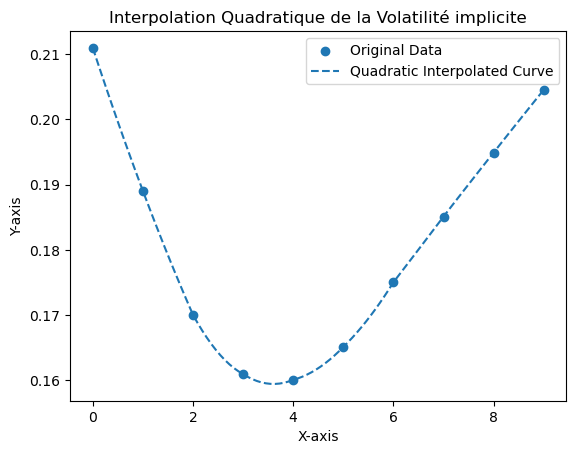

In [83]:
x_original = np.array(data.index)
y_original = np.array(data["implied_vol"])

nb_pts = 100
x_interpolated = np.linspace(x_original.min(), x_original.max(), nb_pts)
vol_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, vol_interpolated, label='Quadratic Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation Quadratique de la Volatilité implicite')
plt.show()

Interpolation des strikes

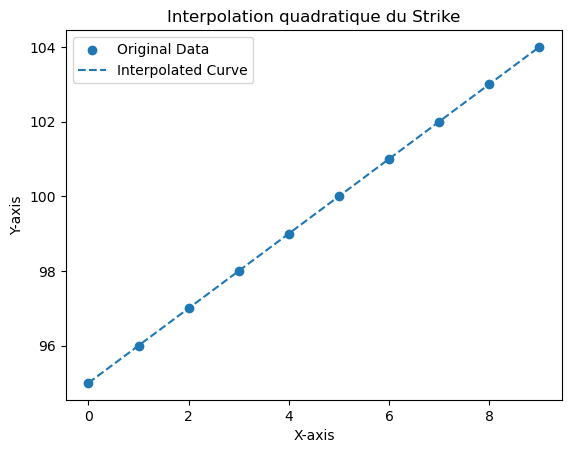

In [84]:
x_original=data.index
y_original=data["strikes"]
nb_pts=100
x_interpolated=np.linspace(x_original.min(), x_original.max(), nb_pts)
strike_interpolated = quadratic_interpolation(x_interpolated, x_original, y_original)

plt.scatter(x_original, y_original, label='Original Data')
plt.plot(x_interpolated, strike_interpolated, label='Interpolated Curve', linestyle='--')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Interpolation quadratique du Strike')
plt.show()

Calcul des prix avec Black-Scholes avec les vol et strike interpolés

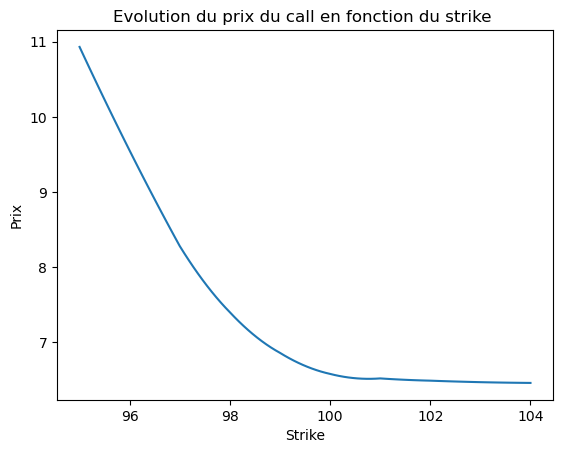

In [85]:
prices=[]

for i,j in zip(strike_interpolated,vol_interpolated):
    prices.append(black_scholes_call_price(S,i,T,r,j))

df=pd.DataFrame([prices,strike_interpolated],index=["Price","Strike"]).T
plt.plot(df["Strike"],df["Price"])
plt.title("Evolution du prix du call en fonction du strike ")
plt.ylabel("Prix")
plt.xlabel("Strike")
plt.show()

In [86]:
def neutral_risk_density(strikes , r , S , T , implied_vols ) :
    density = np.zeros(len(strikes))
    k=df["Strike"][1]-df["Strike"][0]
    
    for i , K in enumerate (strikes) :
        C_plus_k = black_scholes_call_price (S , K + k , T , r , implied_vols[i] ) 
        C_minus_k = black_scholes_call_price (S , K - k , T , r , implied_vols[i] ) 
        C_actuel = black_scholes_call_price (S , K , T , r , implied_vols[i] )

        # Formule de Breeden - Litzenberger 
        density [ i ] = np.exp( r * T ) *(( C_plus_k - 2 * C_actuel + C_minus_k ) / k ** 2)

    return density

density_risque_neutre = neutral_risk_density (strike_interpolated , r , S , T , vol_interpolated )

Afin de comparer nos deux densités, nous devons "fit" notre gaussienne 

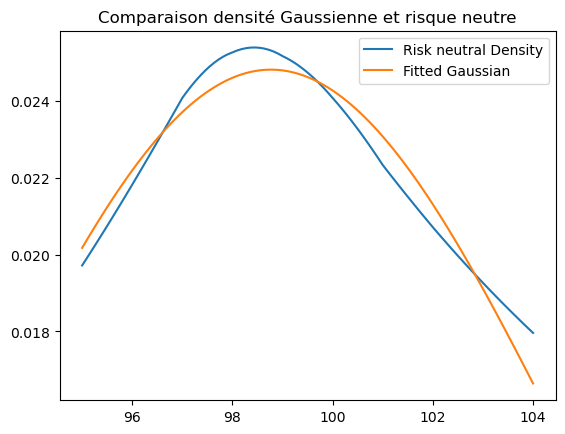

Fitted Mean: 98.7674639939289
Fitted Standard Deviation: 5.854576279872189
Fitted Amplitude (Ratio): 0.364191517778908


In [87]:
def gaussian(x, mu, sigma, ratio):
    return ratio * np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

def objective(params, x, data):
    mu, sigma, ratio = params
    return np.sum((gaussian(x, mu, sigma, ratio) - data)**2)

initial_guess = [100, 5, 2]

result = minimize(objective, initial_guess, args=(df["Strike"], density_risque_neutre))

fitted_mu, fitted_sigma, fitted_ratio = result.x


plt.plot(df["Strike"], density_risque_neutre, label='Risk neutral Density')
plt.plot(df["Strike"], gaussian(df["Strike"], fitted_mu, fitted_sigma, fitted_ratio), label='Fitted Gaussian')
plt.title( "Comparaison densité Gaussienne et risque neutre")
plt.legend()
plt.show()

print("Fitted Mean:", fitted_mu)
print("Fitted Standard Deviation:", fitted_sigma)
print("Fitted Amplitude (Ratio):", fitted_ratio)

2/ Vérifier, en faisant des tirages dans cette loi implicite, si l’on trouve un prix de modèle proche du 
prix de marché pour toutes les options ci-dessus. 

Première méthode : on utilise notre gaussienne fitée

In [88]:
def monte_carlo_simulation(S, K, T, r, sigma, nb_simulations):
    dt=T/252 #car on fait des pas daily
    gaussian_values = gaussian(np.linspace(95,104,nb_simulations), fitted_mu, fitted_sigma, fitted_ratio)  #on génère n simulations sur la plage de strike que nous avons donc (95:104)
    st_price = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * gaussian_values)  #formule de bs pour calculer les prix futurs
    option_price = [black_scholes_call_price(st, K, T, r, sigma) for st in st_price]    #on utilise notre fonction pour calculer le prix de l'option pour chaque simulation
    
    option_price_mc = np.mean(option_price)   #moyenne des valeurs estimées
    
    return option_price_mc


for strike,vol,market_price in zip(data["strikes"],data["implied_vol"],data["prices"]):
    option_price_mc = monte_carlo_simulation(S, strike, T, r, vol, 1000)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}, Sigma = {vol:.2f} : {option_price_mc:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95, Sigma = 0.21 : 10.94
Market Price = 10.93, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 96, Sigma = 0.19 : 9.56
Market Price = 9.55, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 97, Sigma = 0.17 : 8.29
Market Price = 8.28, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 98, Sigma = 0.16 : 7.41
Market Price = 7.40, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 99, Sigma = 0.16 : 6.87
Market Price = 6.86, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 100, Sigma = 0.17 : 6.59
Market Price = 6.58, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 101, Sigma = 0.18 : 6.53
Market Price = 6.52, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 102, Sigma = 0.19 : 6.50
Market Price = 6.49, Difference = 0.01
Prix par simulation de Monte Carlo pour K = 103, Sigma = 0.19 : 6.48
Market Price = 6.47, Difference = 0.01
Prix par simulation de Monte Ca

Deuxième méthode : on utilise une gaussienne centrée réduite

In [117]:
def BS_Call_MC(S,K,T, r,sigma,nb):
    z = np.random.normal(0, 1, [1, nb])
    
    ST = S*np.exp(T*(r - 0.5*sigma**2)+sigma*np.sqrt(T)*z)
    
    payoff = np.mean(np.max(ST - K,0))
    
    return np.exp(-r*T)*payoff



for strike,vol,market_price in zip(data["strikes"],data["implied_vol"],data["prices"]):
    option_price_mc = BS_Call_MC(S, strike, T, r, vol, 10000)
    print(f"Prix par simulation de Monte Carlo pour K = {strike}, Sigma = {vol:.2f} : {option_price_mc:.2f}")
    print(f"Market Price = {market_price:.2f}, Difference = {abs(option_price_mc-market_price):.2f}")

Prix par simulation de Monte Carlo pour K = 95, Sigma = 0.21 : 9.76
Market Price = 10.93, Difference = 1.17
Prix par simulation de Monte Carlo pour K = 96, Sigma = 0.19 : 8.62
Market Price = 9.55, Difference = 0.93
Prix par simulation de Monte Carlo pour K = 97, Sigma = 0.17 : 7.91
Market Price = 8.28, Difference = 0.37
Prix par simulation de Monte Carlo pour K = 98, Sigma = 0.16 : 6.91
Market Price = 7.40, Difference = 0.49
Prix par simulation de Monte Carlo pour K = 99, Sigma = 0.16 : 5.73
Market Price = 6.86, Difference = 1.13
Prix par simulation de Monte Carlo pour K = 100, Sigma = 0.17 : 5.00
Market Price = 6.58, Difference = 1.58
Prix par simulation de Monte Carlo pour K = 101, Sigma = 0.18 : 3.91
Market Price = 6.52, Difference = 2.61
Prix par simulation de Monte Carlo pour K = 102, Sigma = 0.19 : 3.13
Market Price = 6.49, Difference = 3.36
Prix par simulation de Monte Carlo pour K = 103, Sigma = 0.19 : 2.08
Market Price = 6.47, Difference = 4.39
Prix par simulation de Monte Car

4/ Calibrer un modèle à volatilité locale de type SVI en suivant les étapes suivantes : 
- écrire l’algorithme de valorisation d’une option avec le modèle SVI(stochastic volatility inspired), par EDP d’une part et par 
Monte Carlo d’autre part et comparer les résultats pour plusieurs jeux de paramètres ; 


##### voir slide 69 la formule pour le modèle SVI

In [90]:
# Fonction SVI 
def svi(param, x):
    a, b, rho, m, sigma = param
    return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + sigma ** 2))

# Simulation Monte Carlo pour valoriser une option
def monte_carlo_option_valuation(param, num_paths, num_steps, dt, strike, maturity):
    paths = np.zeros((num_paths, num_steps + 1))
    paths[:, 0] = 100  # Prix initial de l'actif
    for i in range(num_steps):
        vol = svi(param, paths[:, i])
        paths[:, i + 1] = paths[:, i] * np.exp(-0.5 * vol * vol * dt + vol * np.sqrt(dt) * np.random.normal(size=num_paths))

    option_payoffs = np.maximum(paths[:, -1] - strike, 0)
    option_value = np.exp(-r * maturity) * np.mean(option_payoffs)

    return option_value

# Paramètres de la simulation Monte Carlo
num_paths = 10000
num_steps = 252  # Nombre de pas de temps
dt = 1 / 252  # Intervalle de temps
strike = 110  # Prix d'exercice de l'option
maturity = 1  # Maturité de l'option
r = 0.05  # Taux d'intérêt

# Paramètres du modèle SVI (à remplacer par vos propres paramètres)
calibrated_params = [0.1, 0.1, -0.5, 100, 0.1]

# Valorisation de l'option par Monte Carlo
option_value_mc = monte_carlo_option_valuation(calibrated_params, num_paths, num_steps, dt, strike, maturity)

print("Valorisation de l'option par Monte Carlo:", option_value_mc)


Valorisation de l'option par Monte Carlo: 2.1500708134169906


- estimez les cinq paramètres permettant de réduire au plus l’erreur moyenne ; 


Paramètres calibrés: [ 1.51190186e-01  1.32677419e-02 -3.07112756e-01  9.82920070e+01
  2.24262626e-01]


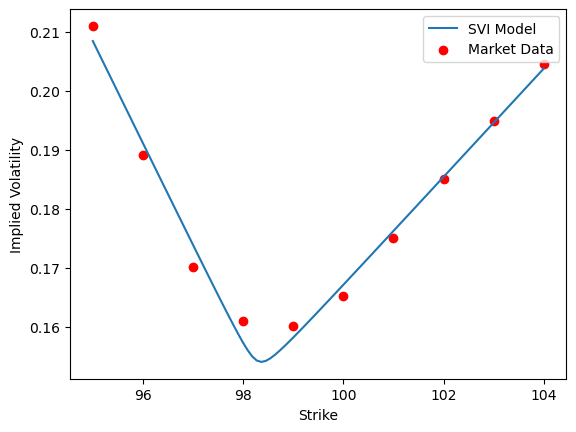

In [91]:
# Fonction de coût à minimiser
def cost_function(param, strikes, vols_market):
    vols_model = [svi(param, x) for x in strikes]
    return np.sum((vols_model - vols_market) ** 2)

# Données de marché
strikes = data["strikes"]
vols_market = data["implied_vol"]

# Initialisation des paramètres
initial_params = [0.1, 0.1, -0.5, 100, 0.1]

# Minimisation de la fonction de coût
result = minimize(cost_function, initial_params, args=(strikes, vols_market), method='L-BFGS-B') #optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory

# Paramètres calibrés
calibrated_params = result.x

# Affichage des résultats
print("Paramètres calibrés:", calibrated_params)

# Visualisation de la surface de volatilité implicite
strikes_plot = np.linspace(min(strikes), max(strikes), 100)
vols_plot = [svi(calibrated_params, x) for x in strikes_plot]

plt.plot(strikes_plot, vols_plot, label='SVI Model')
plt.scatter(strikes, vols_market, color='red', label='Market Data')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()


- on fixe tous les paramètres aux valeurs estimées ci-avant (sauf a et b) et on va calibrer les deux 
paramètres a et b pour chaque option : vous obtiendrez donc une nappe pour chacun de ces 
deux paramètres et vous introduirez une contrainte de régularisation de ces deux nappes dans 
votre problème d’optimisation. 